### Set Up

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics 
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score
import seaborn as sn
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving steam_raw.csv to steam_raw.csv


In [0]:
df = pd.read_csv('./steam_raw.csv')

In [0]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


### Data Cleaning

In [4]:
# remove unwanted columns
to_drop = ['appid', 'name', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'genres', 'steamspy_tags']
df.drop(to_drop, inplace=True, axis=1)

# remove zeros in columns
df['price'] = df['price'].astype(float)
df['achievements'] = df['achievements'].astype(float)
df['average_playtime'] = df['average_playtime'].astype(float)
df = df[df.price != 0]
#df = df[df.achievements != 0]
#df = df[df.average_playtime != 0]
#df = df[df.median_playtime != 0]
df.describe()

,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000
mean,47.752396,784.935346,167.258454,117.085866,116.447767,6.712914
std,366.361743,7827.263120,3482.386936,939.620677,1068.468825,8.014336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000
25%,0.000000,6.000000,2.000000,0.000000,0.000000,2.090000
50%,8.000000,22.000000,8.000000,0.000000,0.000000,4.790000
75%,24.000000,112.000000,37.000000,0.000000,0.000000,7.490000
max,9821.000000,496184.000000,487076.000000,55204.000000,86148.000000,421.990000


In [5]:
# combine ratings
df.insert(1, 'total_ratings', ' ', True)
df.total_ratings = df.positive_ratings+df.negative_ratings;

df.insert(4, 'ratings', ' ', True) 
df['ratings'] = df['positive_ratings']/(df['positive_ratings'] + df['negative_ratings'])

# remove unwanted ratings columns
to_drop = ['positive_ratings', 'negative_ratings']
df.drop(to_drop, inplace=True, axis=1)
df.head()

,release_date,total_ratings,categories,achievements,ratings,average_playtime,median_playtime,owners,price
0,2000-11-01,127873,Multi-player;Online Multi-Player;Local Multi-P...,0.0,0.973888,17612.0,317,10000000-20000000,7.19
1,1999-04-01,3951,Multi-player;Online Multi-Player;Local Multi-P...,0.0,0.839787,277.0,62,5000000-10000000,3.99
2,2003-05-01,3814,Multi-player;Valve Anti-Cheat enabled,0.0,0.895648,187.0,34,5000000-10000000,3.99
3,2001-06-01,1540,Multi-player;Online Multi-Player;Local Multi-P...,0.0,0.826623,258.0,184,5000000-10000000,3.99
4,1999-11-01,5538,Single-player;Multi-player;Valve Anti-Cheat en...,0.0,0.947996,624.0,415,5000000-10000000,3.99


In [0]:
# extract the year
df['release_year'] = pd.DatetimeIndex(df['release_date']).year

# remove release_date column
to_drop = ['release_date']
df.drop(to_drop, inplace=True, axis=1)

# split owners
df[['min_owners','max_owners']] = df['owners'].str.split('-',expand=True)

# calculate average yearly revenue
df.insert(8, 'avg_revenue', ' ', True) 
df['min_owners'] = df['min_owners'].astype(float)
df['max_owners'] = df['max_owners'].astype(float)
df['price'] = df['price'].astype(float)
df['release_year'] = df['release_year'].astype(float)
df['avg_revenue'] = (df['min_owners'] + df['max_owners'])/2 * df['price'] / (2020 - df['release_year'])

# remove columns
to_drop = ['release_year', 'min_owners', 'max_owners', 'owners']
df.drop(to_drop, inplace=True, axis=1)

In [0]:
# insert column for multi-player and single-player
df.insert(1, 'singleplayer', ' ', True) 
df.insert(2, 'multiplayer', ' ', True) 

# make categories lowercase
df['categories'] = df['categories'].str.lower()

# Populate columns with True/False
df['singleplayer'] = df['categories'].str.contains('single-player')
df['multiplayer'] = df['categories'].str.contains('multi-player')

# Change to binary 0/1
df['singleplayer'] = df['singleplayer'].astype(int)
df['multiplayer'] = df['multiplayer'].astype(int)

to_drop = ['categories']
df.drop(to_drop, inplace=True, axis=1)

In [0]:
# mean normalization + feature scaling
achievements_std = df['achievements'].std()
achievements_mean = df.achievements.mean()
df.achievements = (df.achievements - achievements_mean)/achievements_std

price_std = df['price'].std()
price_mean = df.price.mean()
df.price = (df.price - price_mean)/price_std

avg_playtime_std = df['average_playtime'].std()
avg_playtime_mean = df.average_playtime.mean()
df.average_playtime = (df.average_playtime - avg_playtime_mean)/avg_playtime_std

med_playtime_std = df['median_playtime'].std()
med_playtime_mean = df.median_playtime.mean()
df.median_playtime = (df.median_playtime - med_playtime_mean)/med_playtime_std

total_ratings_std = df.total_ratings.std()
total_ratings_mean = df.total_ratings.mean()
df.total_ratings = (df.total_ratings - total_ratings_mean)/total_ratings_std

In [0]:
#df.avg_revenue = np.log(df.avg_revenue)
#df.to_csv('steam_v1.csv')
#files.download('steam_v1.csv')

In [0]:
df.describe()

,total_ratings,singleplayer,multiplayer,achievements,ratings,average_playtime,median_playtime,price,avg_revenue
count,2.451500e+04,24515.000000,24515.000000,2.451500e+04,24515.000000,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04
mean,-1.017752e-15,0.965980,0.178625,-3.843523e-15,0.713999,-1.726036e-14,2.102354e-14,-6.702102e-14,3.047743e+05
std,1.000000e+00,0.181284,0.383046,1.000000e+00,0.238622,1.000000e+00,1.000000e+00,1.000000e+00,5.125625e+06
min,-9.127948e-02,0.000000,0.000000,-1.303422e-01,0.000000,-1.246097e-01,-1.089856e-01,-7.976848e-01,1.316667e+03
25%,-9.051177e-02,1.000000,0.000000,-1.303422e-01,0.582116,-1.246097e-01,-1.089856e-01,-5.768306e-01,9.975000e+03
50%,-8.820866e-02,1.000000,0.000000,-1.085059e-01,0.764706,-1.246097e-01,-1.089856e-01,-2.399343e-01,2.330000e+04
75%,-7.630924e-02,1.000000,0.000000,-6.483318e-02,0.897436,-1.246097e-01,-1.089856e-01,9.696203e-02,5.905000e+04
max,9.426527e+01,1.000000,1.000000,2.667650e+01,1.000000,5.862676e+01,8.051854e+01,5.181678e+01,6.747500e+08


In [9]:
# dropping average_playtime and median_playtime
to_drop = ['average_playtime', 'median_playtime']
df.drop(to_drop, inplace=True, axis=1)
df.head()

,total_ratings,singleplayer,multiplayer,achievements,ratings,price,avg_revenue
0,12.179710,0,1,-0.130342,0.973888,0.059529,5.392500e+06
1,0.287775,0,1,-0.130342,0.839787,-0.339755,1.425000e+06
2,0.274628,0,1,-0.130342,0.895648,-0.339755,1.760294e+06
3,0.056408,0,1,-0.130342,0.826623,-0.339755,1.575000e+06
4,0.440068,1,1,-0.130342,0.947996,-0.339755,1.425000e+06


In [0]:
df.shape

(24515, 7)

### Binning data

In [0]:
# Run this if rerunning binning

#df.hist(column='avg_revenue', bins ='auto')
to_drop = ['bin']
df.drop(to_drop, inplace=True, axis=1)

KeyError: ignored

In [10]:
# Split into bins
df.insert(7, 'bins', ' ', True) 
bin_num = np.linspace(start=0,stop=3,num=4)
df.bins = pd.qcut(df.avg_revenue, q=4, labels=bin_num)

#bins_revenue = [0, 10000, 50000, 200000, 1000000, 20000000, 700000000]
#df.bins = pd.cut(df.avg_revenue, bins=bins_revenue, labels=bin_num)
df['bins'] = df['bins'].astype(int)
df.head()

,total_ratings,singleplayer,multiplayer,achievements,ratings,price,avg_revenue,bins
0,12.179710,0,1,-0.130342,0.973888,0.059529,5.392500e+06,3
1,0.287775,0,1,-0.130342,0.839787,-0.339755,1.425000e+06,3
2,0.274628,0,1,-0.130342,0.895648,-0.339755,1.760294e+06,3
3,0.056408,0,1,-0.130342,0.826623,-0.339755,1.575000e+06,3
4,0.440068,1,1,-0.130342,0.947996,-0.339755,1.425000e+06,3


### Split data into training and test

In [0]:
# split data
X = df[['singleplayer', 'multiplayer', 'ratings', 'total_ratings', 'achievements', 'price']].values
y = df['bins'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, shuffle='true')
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle='true')

### Confusion Matrix Code

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 0. Linear Regression

In [0]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)
y_pred = np.exp(y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.exp(y_train), y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(np.exp(y_train), y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.exp(y_train), y_pred)))
print('Variance score: %.2f' % metrics.r2_score(np.exp(y_train), y_pred))

Mean Absolute Error: 39919660.27567719
Mean Squared Error: 2.3411147570629304e+19
Root Mean Squared Error: 4838506750.086157
Variance score: -418001030852263552.00


In [0]:
y_pred

array([3.50927335, 4.01526026, 4.00626693, ..., 5.36967911, 5.67178216,
       3.66764112])

In [0]:
np.exp(y_train)

array([20.08553692,  2.71828183,  2.71828183, ...,  7.3890561 ,
        7.3890561 , 20.08553692])

In [0]:
y_pred = reg.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Variance score: %.2f' % metrics.r2_score(y_val, y_pred))

Mean Absolute Error: 1.0515304969275525
Mean Squared Error: 1.5497007278966493
Root Mean Squared Error: 1.2448697634277448
Variance score: -0.22


### 1. Logistic Regression

In [12]:
# Log reg

# Fit to training set
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=3000)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Predictions on training set
y_pred_train = model.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2, 3])
# pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

array([[3249,  579,   36,    0],
       [1051, 1778,  879,   34],
       [ 291, 1101, 1628,  432],
       [ 196,  333,  635, 2487]])

In [14]:
metrics.f1_score(y_train, y_pred_train, average='micro') 

0.6215242368617853

In [15]:
y_train_b = label_binarize(y_train, bin_num)
y_pred_train_b = label_binarize(y_pred_train, bin_num)
roc_auc_score(y_train_b, y_pred_train_b)

0.7454473364354017

In [16]:
# Predictions on val set
y_pred_val = model.predict(X_val)
metrics.confusion_matrix(y_val, y_pred_val, labels=[0, 1, 2, 3])

array([[1096,  195,   16,    1],
       [ 343,  584,  272,    9],
       [ 120,  359,  542,  125],
       [  55,  113,  206,  867]])

In [17]:
metrics.f1_score(y_val, y_pred_val, average='micro') 

0.6300224352437284

In [18]:
y_val_b = label_binarize(y_val, bin_num)
y_pred_val_b = label_binarize(y_pred_val, bin_num)
roc_auc_score(y_val_b, y_pred_val_b)

0.7499984391067278

In [19]:
# Test set
y_pred_test = model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])

array([[1057,  180,   11,    0],
       [ 374,  587,  292,    7],
       [  96,  392,  530,  140],
       [  62,  110,  204,  861]])

In [20]:
metrics.f1_score(y_test, y_pred_test, average='micro') 

0.6190087701407302

In [21]:
y_test_b = label_binarize(y_test, bin_num)
y_pred_test_b = label_binarize(y_pred_test, bin_num)
roc_auc_score(y_test_b, y_pred_test_b)

0.7447889406525484

<Figure size 432x288 with 0 Axes>

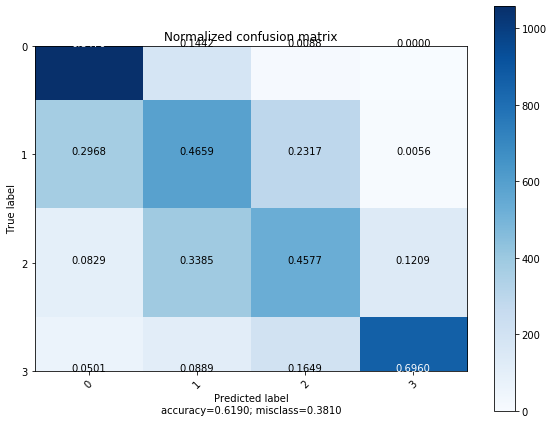

In [34]:
# Plot normalized confusion matrix
plt.figure()
cm = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, normalize=True, target_names=['0','1','2','3'],
                      title='Normalized confusion matrix')
plt.show()

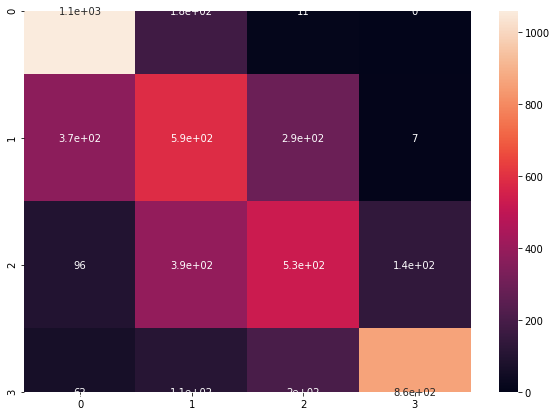

In [24]:
#array = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
#df_cm = pd.DataFrame(array, index = [i for i in "0123"],
#                  columns = [i for i in "0123"])
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)

In [0]:
# Learning Curve

# Learning curve
iter_num = np.linspace(start=1000,stop=2000,num=9)
f1_array_train = np.zeros(10)
f1_array_val = np.zeros(10)

for i in iter_num:
  model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=i)
  model.fit(X_train,y_train)

  # training set
  y_pred = model.predict(X_train)
  f1_array_train[i] = metrics.f1_score(y_train, y_pred, average='micro') 
  
  # val set
  y_val_pred = model.predict(X_val)
  f1_array_val = metrics.f1_score(y_train, y_val_pred, average='micro')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


IndexError: ignored

In [0]:
iter_num = np.linspace(start=1000,stop=2000,num=9)
iter_num

array([1000., 1125., 1250., 1375., 1500., 1625., 1750., 1875., 2000.])

### 2. Neural Net

In [0]:
# Neural Net
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100),max_iter=800)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=800, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
# training set prediction
y_pred_train = mlp.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2, 3])

array([[3191,  476,   62,   49],
       [ 933, 2129,  513,  139],
       [ 211,  652, 2122,  474],
       [  90,  125,  603, 2940]])

In [0]:
metrics.f1_score(y_train, y_pred_train, average='micro') 

0.7058263648106602

In [0]:
y_train_b = label_binarize(y_train, bin_num)
y_pred_train_b = label_binarize(y_pred_train, bin_num)
roc_auc_score(y_train_b, y_pred_train_b)

0.8027066586948616

In [0]:
# val set prediction
y_val_pred = mlp.predict(X_val)
metrics.confusion_matrix(y_val, y_val_pred, labels=[0, 1, 2, 3])

array([[1091,  171,   47,   17],
       [ 318,  693,  211,   43],
       [  85,  238,  670,  167],
       [  26,   39,  216,  871]])

In [0]:
metrics.f1_score(y_val, y_val_pred, average='micro') 

0.6746889659392209

In [0]:
y_val_b = label_binarize(y_val, bin_num)
y_pred_val_b = label_binarize(y_val_pred, bin_num)
roc_auc_score(y_val_b, y_pred_val_b)

0.7936066504230048

In [0]:
# Test set
y_pred_test = model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])

In [0]:
metrics.f1_score(y_test, y_pred_test, average='micro') 

In [0]:
y_test_b = label_binarize(y_test, bin_num)
y_pred_test_b = label_binarize(y_pred_test, bin_num)
roc_auc_score(y_test_b, y_pred_test_b)

In [0]:
# Plot normalized confusion matrix
plt.figure()
cm = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, normalize=True, target_names=['0','1','2','3'],
                      title='Normalized confusion matrix')
plt.show()

In [0]:
# Learning curve
node_num = np.zeros(10)
f1_array_train = np.zeros(10)
f1_array_val = np.zeros(10)

for i in range(0,10):
  j = (i+1)*10
  mlp = MLPClassifier(hidden_layer_sizes=(j, j, j, j),max_iter=1000)
  mlp.fit(X_train,y_train)

  # training set
  y_pred = mlp.predict(X_train)
  f1_array_train[i] = metrics.f1_score(y_train, y_pred, average='micro') 
  
  # val set
  y_val_pred = mlp.predict(X_val)
  f1_array_val[i] = metrics.f1_score(y_val, y_val_pred, average='micro') 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


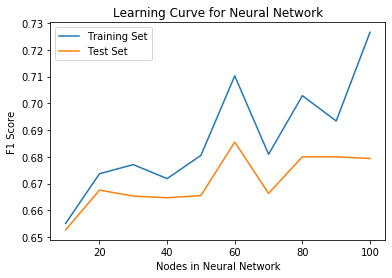

In [0]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], f1_array_train, label='Training Set')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], f1_array_val, label='Test Set')
plt.xlabel('Nodes in Neural Network')
plt.ylabel('F1 Score')
plt.title('Learning Curve for Neural Network')
plt.legend()
plt.show()

### 3. Decision trees

In [0]:
# Decision trees
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.get_depth()

33

In [0]:
# training set prediction
y_pred_train = clf.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2, 3])

array([[3720,   54,    4,    0],
       [ 102, 3595,   17,    0],
       [  13,  109, 3337,    0],
       [   2,    7,   40, 3709]])

In [0]:
metrics.f1_score(y_train, y_pred_train, average='micro') 

0.9763410157046706

In [0]:
y_train_b = label_binarize(y_train, bin_num)
y_pred_train_b = label_binarize(y_pred_train, bin_num)
roc_auc_score(y_train_b, y_pred_train_b)

0.984088822050992

In [0]:
# val set prediction
y_pred_val = clf.predict(X_val)
metrics.confusion_matrix(y_val, y_pred_val, labels=[0, 1, 2, 3])

array([[961, 256,  78,  31],
       [274, 680, 223,  88],
       [ 75, 254, 595, 236],
       [ 25,  72, 211, 844]])

In [0]:
metrics.f1_score(y_val, y_pred_val, average='micro') 

0.6281868243932286

In [0]:
y_val_b = label_binarize(y_val, bin_num)
y_pred_val_b = label_binarize(y_pred_val, bin_num)
roc_auc_score(y_val_b, y_pred_val_b)

0.7514862970582713

In [0]:
# Test set
y_pred_test = model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])

In [0]:
metrics.f1_score(y_test, y_pred_test, average='micro') 

In [0]:
y_test_b = label_binarize(y_test, bin_num)
y_pred_test_b = label_binarize(y_pred_test, bin_num)
roc_auc_score(y_test_b, y_pred_test_b)

In [0]:
# Plot normalized confusion matrix
plt.figure()
cm = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, normalize=True, target_names=['0','1','2','3'],
                      title='Normalized confusion matrix')
plt.show()

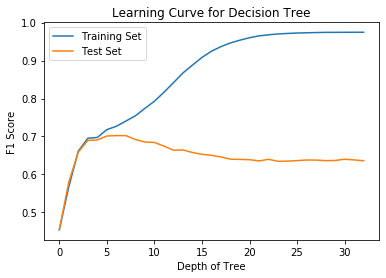

In [0]:
# Learning Curve
depth_array = list(range(33))
f1_array_train = np.zeros(33)
f1_array_val = np.zeros(33)

for i in depth_array:
  clf = tree.DecisionTreeClassifier(max_depth=i+1)
  clf = clf.fit(X_train, y_train)

  # training set
  y_pred = clf.predict(X_train)
  f1_array_train[i] = metrics.f1_score(y_train, y_pred, average='micro') 
  
  # val set
  y_val_pred = clf.predict(X_val)
  f1_array_val[i] = metrics.f1_score(y_val, y_val_pred, average='micro') 

plt.plot(depth_array, f1_array_train, label='Training Set')
plt.plot(depth_array, f1_array_val, label='Test Set')
plt.xlabel('Depth of Tree')
plt.ylabel('F1 Score')
plt.title('Learning Curve for Decision Tree')
plt.legend()
plt.show()

### 4. Neural Net with Regression

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), max_iter=1000, shuffle=True, random_state=1)
mlp.fit(X_train,y_train)
mlp.score(X_train,y_train)

NameError: ignored

In [0]:
y_pred = mlp.predict(X_train)
y_pred = np.exp(y_pred)
y_train_true = np.exp(y_train)

In [0]:
y_pred

array([  35015.92188874,   57239.44348829,   29719.64232066, ...,
         22734.18838824, 1862973.8515516 ,   12518.4921178 ])

In [0]:
max_ind = np.argmax(y_train_true)
y_train_true[max_ind] - y_pred[max_ind]

606891918.0090293

In [0]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

Mean Absolute Error: 144752.6424564186
Mean Squared Error: 1012217267437.7675
Root Mean Squared Error: 1006090.0891261018


In [0]:
mlp.score(X_val,y_val)

0.8365937874662147

In [0]:
y_pred = mlp.predict(X_vak)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.48286333021255895
Mean Squared Error: 0.40173801482877813
Root Mean Squared Error: 0.6338280640905529


In [0]:
y_pred

array([10.4573232 , 10.71698652, 10.74902193, ...,  9.46241054,
        9.55069   , 11.11969573])

In [0]:
y_val

array([  13930.        ,   97450.        ,   23300.        , ...,
         23300.        , 3212142.85714286,    7980.        ])